In [3]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import batman

from lmfit import minimize,Parameters,Parameter,report_fit

Populating the interactive namespace from numpy and matplotlib


In [4]:
def transitmin(params, time, flux, fluxerr):
    """ Calculate the transit light curve and the difference from the observed flux """
    parbat = batman.TransitParams()
    parbat.t0 = params['t0'].value      # time of transit
    parbat.per = params['per'].value    # orbital period
    parbat.rp = params['rp'].value      # planet radius (in units of stellar radii)
    parbat.a = params['a'].value        # semi-major axis (in units of stellar radii)
    parbat.inc = params['inc'].value    # orbital inclination (in degrees)
    parbat.ecc = params['ecc'].value    # eccentricity
    parbat.w = params['w'].value        # longitude of periastron (in degrees)
    parbat.u = [params['u1'].value, params['u2'].value]    # limb darkening coefficients
    parbat.limb_dark = "quadratic"                         # limb darkening model

    m = batman.TransitModel(parbat, time, supersample_factor=21, exp_time=0.5/24.)
    model = m.light_curve(parbat)
    return (model - flux)/fluxerr

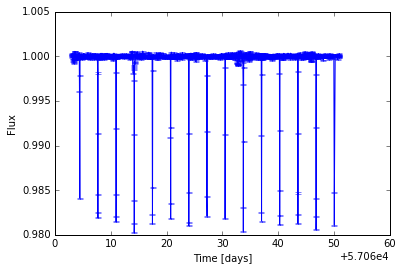

In [7]:
## read the light curve
filename = '../ktwo211089792.txt'


time, lc, lcerror = np.genfromtxt(filename, unpack=True)

## plot the light curve
# ...
plt.errorbar(time, lc, lcerror)
plt.xlabel('Time [days]')
plt.ylabel('Flux')

In [8]:
# parameters obtained from the BLS
period = 3.26083740
epoch = 57064.424499
depth = 0.139772
duration = 0.07909


time = time-epoch

# set up iniital parameters
# estimate a/rs and rp/rs
g = 6.67428e-11
gm = 1.32712440041e20
msun = gm/g
rsun = 6.95508e8
sdensity = 1.0
aoverr = (sdensity*(gm*(period*24.*3600.0)**2.)/(4.*np.pi**2.*rsun**3.))**(1./3.)
rp = np.sqrt(depth)

# Assume  limb darkening
u1 = 0.4983
u2 = 0.2042

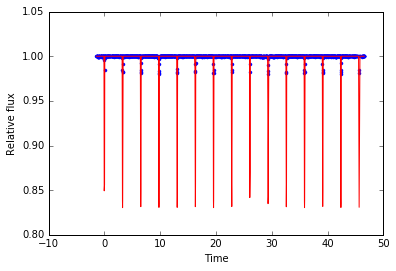

In [9]:
# set up the parameters for batman
params2 = batman.TransitParams()
params2.t0 = 0.0                       #time of inferior conjunction
params2.per = period                    #orbital period
params2.rp = rp                     #planet radius (in units of stellar radii)
params2.a = aoverr                       #semi-major axis (in units of stellar radii)
params2.inc = 89.                     #orbital inclination (in degrees)
params2.ecc = 0.                      #eccentricity
params2.w = 90.                       #longitude of periastron (in degrees)
params2.u = [u1, u2]                #limb darkening coefficients
params2.limb_dark = "quadratic"       #limb darkening model



# calculate and plot the starting model
m = batman.TransitModel(params2, time, supersample_factor = 21, exp_time = 0.5/24.)    #initializes model
model = m.light_curve(params2)

plt.figure()
plt.plot(time, lc, '.')
plt.plot(time,  model, color='r')
plt.xlabel("Time")
plt.ylabel("Relative flux")
plt.show()

In [10]:
# create a set of parameters for lmfit
# the ones that are fixed have vary=false
params = Parameters()
params.add('t0', value = 0.0)
params.add('per', value = period, vary = True)
params.add('rp', value = rp, min=0)
params.add('a', value = aoverr, min=1)
params.add('inc', value = 88.)
params.add('ecc', value = 0.0, vary = False)
params.add('w', value = 90., vary = False)
params.add('u1', value = u1, vary = False)
params.add('u2', value = u2, vary = False)

In [11]:
# use lmfit to estimate the transit parameters
result = minimize(transitmin,params, args=(time, lc, lcerror))

report_fit(result)

[[Fit Statistics]]
    # function evals   = 95
    # data points      = 1919
    # variables        = 5
    chi-square         = 44053.230
    reduced chi-square = 23.016
    Akaike info crit   = 6023.368
    Bayesian info crit = 6051.166
[[Variables]]
    t0:    0.00823358 +/- 0.000144 (1.75%) (init= 0)
    per:   3.25872421 +/- 1.83e-05 (0.00%) (init= 3.260837)
    rp:    0.13169153 +/- 0.001124 (0.85%) (init= 0.3738609)
    a:     10.7257521 +/- 0.289619 (2.70%) (init= 9.256435)
    inc:   86.6846809 +/- 0.239511 (0.28%) (init= 88)
    ecc:   0 (fixed)
    w:     90 (fixed)
    u1:    0.4983 (fixed)
    u2:    0.2042 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, inc)                    =  0.998 
    C(rp, inc)                   = -0.981 
    C(rp, a)                     = -0.972 
    C(t0, per)                   = -0.844 


In [13]:
# recover the fitted parameters from the result
parbat = batman.TransitParams()
parbat.t0 = result.params['t0'].value                     #time of inferior conjunction
parbat.per = result.params['per'].value                    #orbital period
parbat.rp = result.params['rp'].value                      #planet radius (in units of stellar radii)
parbat.a = result.params['a'].value                      #semi-major axis (in units of stellar radii)
parbat.inc = result.params['inc'].value                     #orbital inclination (in degrees)
parbat.ecc = 0.                      #eccentricity
parbat.w = 90.                       #longitude of periastron (in degrees)
parbat.u = [u1, u2]                #limb darkening coefficients
parbat.limb_dark = "quadratic"       #limb darkening model

period = result.params['per'].value
epoch0 = result.params['t0'].value

#phase fold to plot
phase0 = (time)/period
phase = phase0%1
phadur = duration*2.2/period

phase[np.where(phase>0.5)[0]]-=1
cond = np.where(abs(phase) < phadur)[0]

timefold = phase[cond]*period
fluxfold = lc[cond]

fluxfold = fluxfold[np.argsort(timefold)]
timefold = np.sort(timefold)


# calculate and plot the two models initial model for the time folded dataset
m = batman.TransitModel(params2, timefold, supersample_factor = 21, exp_time = 0.5/24.)
model = m.light_curve(params2)


m = batman.TransitModel(parbat, timefold, supersample_factor = 21, exp_time = 0.5/24.)
fitmodel = m.light_curve(parbat)

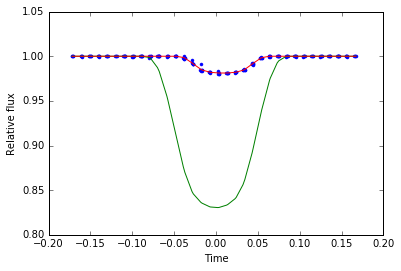

In [14]:
plt.figure()
plt.plot(timefold, fluxfold, '.')
plt.plot(timefold,  model, color='g')
plt.plot(timefold,  fitmodel, color='r')
plt.xlabel("Time")
plt.ylabel("Relative flux")
plt.show()

In [15]:
#### Cut the transits and write them to a file
filename = 'cuttransits.txt'

fp = open(filename, 'w')
for i in cond:
    fp.write('%.10f\t%f\t%f\n'%(time[i]+epoch, lc[i], lcerror[i]))
fp.close()